In [16]:
import os
import pickle
import numpy as np
import pandas as pd
import pydicom
import re
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
%matplotlib inline

# Set Color Palettes for the notebook (https://color.adobe.com/)
colors_nude = ['#FFE61A','#B2125F','#FF007B','#14B4CC','#099CB3']

# Set Style
sns.set_style("whitegrid")

In [17]:
#### Defining constants and loading data
INCLUDE_CT_DATA = True
USE_PICKLED_DATA = True
IMAGE_PATH = "input/osic-pulmonary-fibrosis-progression/"
test_pickle_path = "./testing_df_unique_patients_ct.pkl"
train_pickle_path = "./training_df_unique_patients_ct.pkl"

df_train = pd.read_csv(IMAGE_PATH + 'train.csv')
df_test = pd.read_csv(IMAGE_PATH + 'test.csv')


In [18]:
def read_dicom(patient_id, picture_id):
    # read a dcm file for a particular patient
    dcm_file_path = IMAGE_PATH + 'train/' + str(patient_id) + '/' + str(picture_id) + '.dcm'
    dcm = None
    try:
        dcm = pydicom.read_file(dcm_file_path)
    except:
        print('Could not read dicom file {} of patient {}'.format(picture_id, patient_id))
    return dcm

def get_all_patient_datasets(patient_id, patient_dir='train'):
    directory = IMAGE_PATH + patient_dir + "/" + patient_id
    datasets = []

    # First Order the files in the dataset
    files = []
    for dcm in list(os.listdir(directory)):
        files.append(dcm)
    if len(files) == 0:
        print('No datasets found for patient {} in directory {}'.format(patient_id, patient_dir))
        return None
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    # Read in the Dataset
    for dcm in files:
        path = directory + "/" + dcm
        try:
            datasets.append(pydicom.dcmread(path))
        except:
            print('Could not read dicom file for patient {} in directory {}'.format(patient_id, patient_dir))
            continue

    return datasets

def get_patient_id(dcm):
    if (0x0010, 0x0020) not in dcm:
        return None
    return dcm[0x0010, 0x0020].value

def get_slice_location(dcm):
    if (0x0020, 0x1041) not in dcm:
        print('Key for "Slice Location" does not exist')
        return None
    return float(dcm[0x0020, 0x1041].value)

def get_slice_thickness(dcm):
    if (0x0018, 0x0050) not in dcm:
        print('Key for "Slice Thickness" does not exist')
        return None
    return np.abs(float(dcm[0x0018, 0x0050].value))

def get_pixel_spacings(dcm):
    """
    :param dcm:
    :return: list of two values: [row_spacing, column_spacing]
    """
    if (0x0028, 0x0030) not in dcm:
        return None
    return dcm[0x0028, 0x0030].value

def get_slice_distance(patient_id: str, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    if len(datasets) < 2:
        print('Less than 2 datasets available for patient {} in directory {}'.format(patient_id, patient_dir))
        return None

    i = 0
    while i < len(datasets):
        if not get_slice_location(datasets[i]) or not get_slice_location(datasets[i+1]):
            i += 1
            continue
        distance = np.abs(get_slice_location(datasets[i]) - get_slice_location(datasets[i+1]))
        if distance > 20:
            i += 1
            continue
        if distance > 0:
            return distance
        i += 1
        continue

    # if get_slice_location does not return anything useful, continue with get_slice_thickness
    i = 0
    while i < len(datasets):
        if not get_slice_thickness(datasets[i]) or get_slice_thickness(datasets[i]) > 20:
            i += 1
            continue
        distance = get_slice_thickness(datasets[i])
        if distance > 0:
            return distance
        i += 1
        continue

    print('Could not get valid slice distance')
    return None

def get_square_mm_per_pixel(patient_id: str, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    if not datasets or len(datasets) == 0:
        return None
    if not get_pixel_spacings(datasets[0]):
        return None
    spacings = get_pixel_spacings(datasets[0])
    return spacings[0] * spacings[1]

def get_tissue_pixels(applied_mask, img_cropped):
    try:
        black_filter = (applied_mask > 0.2) & (applied_mask < 0.7)
        non_black = img_cropped[black_filter]
    except:
        print('Could not filter tissue')
        return 0
    return len(non_black)

def make_lungmask(img, display=False):
    try:
        # https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
        img = crop_borders(img)
        row_size= img.shape[0]
        col_size = img.shape[1]
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std

        # Find the average pixel value near the lungs to renormalize washed out images
        middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
        mean = np.mean(middle)
        max = np.max(img)
        min = np.min(img)

        # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean

        # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

        # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.
        # We don't want to accidentally clip the lung.

        eroded = morphology.erosion(thresh_img,np.ones([3,3]))
        dilation = morphology.dilation(eroded,np.ones([8,8]))

        labels = measure.label(dilation) # Different labels are displayed in different colors
        regions = measure.regionprops(labels)

        good_labels = []
        for prop in regions:
            B = prop.bbox
            height_check = row_size * 0.1 < B[2]-B[0] < row_size * 0.8
            width_check = col_size * 0.1 < B[3]-B[1] < col_size * 0.8
            position_row_check = B[0] > row_size * 0.2
            position_column_check = B[2] < col_size * 0.8
            if height_check and width_check and position_row_check and position_column_check:
                good_labels.append(prop.label)
            if len(good_labels) > 4:
                print('Lung mask contains more than 4 areas.')
                return False

        if len(good_labels) < 2:
            print('Lung mask contains less than 2 areas.')
            return False
        mask = np.ndarray([row_size,col_size],dtype=np.int8)
        mask[:] = 0

        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask

        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        if np.all(mask == 0):
            print('Black Image')
            return False
        applied_mask = mask*img
        tissue_only = np.where((applied_mask > 0.2) & (applied_mask < 0.7), 1, 0)

        if (display):
            fig, ax = plt.subplots(4, 2, figsize=[12, 12])
            ax[0, 0].set_title("Original")
            ax[0, 0].imshow(img, cmap='gray')
            ax[0, 0].axis('off')
            ax[0, 1].set_title("Threshold")
            ax[0, 1].imshow(thresh_img, cmap='gray')
            ax[0, 1].axis('off')
            ax[1, 0].set_title("After Erosion and Dilation")
            ax[1, 0].axis('off')
            ax[1, 0].imshow(dilation, cmap='gray')
            ax[1, 1].set_title("Color Labels")
            ax[1, 1].imshow(labels)
            ax[1, 1].axis('off')
            ax[2, 0].set_title("Final Mask")
            ax[2, 0].imshow(mask, cmap='gray')
            ax[2, 0].axis('off')
            ax[2, 1].set_title("Apply Mask on Original")
            ax[2, 1].imshow(mask*img, cmap='gray')
            ax[2, 1].axis('off')
            ax[3, 0].set_title("Tissue only")
            ax[3, 0].imshow(tissue_only, cmap='inferno')
            ax[3, 0].axis('off')
            plt.show()
        return img, applied_mask, mask
    except:
        return img, img, img

def analyse_patient_slices(patient_id, patient_dir='train'):
    # Set fallback lung data
    lung_data_default = (patient_id, 0, 0, 0, 0, 0, 0)
    try:
        datasets = get_all_patient_datasets(patient_id, patient_dir)
        if not datasets or len(datasets) == 0:
            return lung_data_default
        total_lung_pixels = 0
        total_tissue_within_lung_pixels = 0
        number_slices = len(datasets)
        for i in range(1, len(datasets) +1):
            print('.', end='')
            img, applied_mask, mask = None, None, None
            try:
                img, applied_mask, mask = make_lungmask(datasets[i-1].pixel_array)
            except:
                if number_slices > 0:
                    number_slices -= 1
                print('Mask creation skipped: Set {} patient {}'.format(i, patient_id))
                continue
            if mask is None:
                print('Lung mask of CT number {} of patient {} was None'.format(i, patient_id))
                if number_slices > 0:
                    number_slices -= 1
                continue
            lung_pixels = np.count_nonzero(mask == 1)
            tissue_within_lung_pixels = get_tissue_pixels(applied_mask, img)

            width, height = mask.shape
            total_pixels = width * height
            total_lung_pixels += lung_pixels
            total_tissue_within_lung_pixels += tissue_within_lung_pixels

            lung_percentage = np.round(lung_pixels / total_pixels * 100, 0)
            # print('Slice {}: {} Lung, {} Total, {} % Lung'.format(i, lung_pixels, total_pixels, lung_percentage))
        if number_slices == 0:
            return lung_data_default
        avg_slice_lung_pixels = total_lung_pixels/number_slices
        avg_tissue_within_lung_pixels = total_tissue_within_lung_pixels/number_slices
        slice_distance = get_slice_distance(patient_id, patient_dir=patient_dir)

        if not get_square_mm_per_pixel(patient_id, patient_dir=patient_dir) or not slice_distance:
            return lung_data_default

        mm2_per_pixel = get_square_mm_per_pixel(patient_id, patient_dir=patient_dir)
        avg_slice_lung_area_mm = avg_slice_lung_pixels * mm2_per_pixel
        avg_slice_fibrotic_tissue_area_mm = avg_tissue_within_lung_pixels * mm2_per_pixel
        lung_volume_mm3 = np.ceil(number_slices * slice_distance * avg_slice_lung_area_mm)
        lung_volume_cm3 = np.ceil(lung_volume_mm3 / 1000)
        lung_volume_liter = np.round(lung_volume_cm3 / 1000, 2)
        # print('Patient ID: ' + patient_id)
        # print('Number of Slices: ', number_slices)
        # print('Total Lung Pixels: ', total_lung_pixels)
        # print('Percentage fibrotic tissue', tissue_within_lung_pixels / lung_pixels)
        # print('Average lung pixels: ', avg_slice_lung_pixels)
        # print('Average lung area in mm²: ', avg_slice_lung_area_mm)
        # print('Slice distance: ', slice_distance)
        # print('Lung volume in cm³: ', lung_volume_cm3)
        # print('Lung volume in liter: ', lung_volume_liter)
        # print('###')
        return \
            patient_id, \
            lung_volume_cm3, \
            number_slices, \
            slice_distance, \
            avg_slice_lung_area_mm, \
            avg_slice_fibrotic_tissue_area_mm, \
            mm2_per_pixel
    except:
        return lung_data_default

def crop_borders(img):
    try:
        img = img[~np.all(img == img[0,:], axis=1)]
        img = img[:,~np.all(img == img[0,:], axis=0)]
    except:
        print('Could not crop borders')
    return img

def plot_all_patient_images(patient_id, only_mask=True, patient_dir='train'):
    datasets = get_all_patient_datasets(patient_id, patient_dir)
    columns = 10
    rows = int(np.ceil(len(datasets) / 10))
    fig=plt.figure(figsize=(16, rows * 2))

    for i in range(1, len(datasets) +1):
        img, applied_mask, mask = None
        try:
            img, applied_mask, mask = make_lungmask(datasets[i-1].pixel_array)[1]
        except AttributeError:
            print('Could not make lung mask of picture', i)
        if only_mask:
            displayed_img = mask
        else:
            displayed_img = applied_mask

        if displayed_img is not None :
            fig.add_subplot(rows, columns, i)
            plt.imshow(displayed_img)
            plt.title(i, fontsize = 9)
            plt.axis('off')

def show_all_masks(patient_id, picture_id):
    # Show all masks of one picture
    dataset = read_dicom(patient_id, picture_id)

    img = dataset.pixel_array
    # Masked image
    make_lungmask(img, display=True)
    # except:
    #     print('Could not convert image to pixels')

def cat_to_binary(value, cat_name):
    if value == cat_name:
        return 1
    else:
        return 0

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    try:
        sd_clipped = np.maximum(confidence, 70)
        delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
        metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

        if return_values:
            return metric
        else:
            return np.mean(metric)
    except:
        print('Could not calculate LLL')
        return 0

def calculate_gradient_coef_for_patient(patient_records_df):
    X_train = patient_records_df[['Weeks']]
    y_train = patient_records_df[['FVC']]
    try:
        model = LinearRegression(normalize=True).fit(X_train, y_train)
        return model.coef_[0][0]
    except:
        print('Could not fit LinearRegression model')
        return 0

def prepare_patient_data(df_raw, patient_id, df_new):
    try:
        # Filter by single patients
        patient_records_df = df_raw[df_raw.Patient == patient_id]
        number_records = len(patient_records_df)
        gradient_coef = calculate_gradient_coef_for_patient(patient_records_df)
        max_fvc = patient_records_df[['FVC']].max()[0]
        min_fvc = patient_records_df[['FVC']].min()[0]
        std_fvc = patient_records_df[['FVC']].std()[0]
        if np.isnan(std_fvc):
            std_fvc = 0

        first_measurement = patient_records_df.iloc[0]
        last_measurement = patient_records_df.iloc[number_records - 1]
        diff_abs_fvc = last_measurement['FVC'] - first_measurement['FVC']
        # print('L {} - F {} = {}'.format(last_measurement['FVC'], first_measurement['FVC'], diff_abs_fvc))
        df_unique_patient = pd.DataFrame(
            index=[patient_id],
            columns=[
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC'
            ],
            data=[[
                first_measurement['FVC'],
                last_measurement['FVC'],
                diff_abs_fvc,
                gradient_coef,
                max_fvc,
                min_fvc,
                std_fvc]]
        )
        df_unique_patient['First_Week'] = first_measurement['Weeks']
        df_unique_patient['Percent'] = first_measurement['Percent']
        df_unique_patient['Age'] = first_measurement['Age']
        df_unique_patient['Sex'] = first_measurement['Sex']
        df_unique_patient['SmokingStatus'] = first_measurement['SmokingStatus']
        df_unique_patient['Male'] = cat_to_binary(first_measurement['Sex'], 'Male')
        df_unique_patient['Female'] = cat_to_binary(first_measurement['Sex'], 'Female')
        df_unique_patient['NeverSmoked'] = cat_to_binary(first_measurement['SmokingStatus'], 'Never smoked')
        df_unique_patient['ExSmoker'] = cat_to_binary(first_measurement['SmokingStatus'], 'Ex-smoker')
        df_unique_patient['CurrentlySmokes'] = cat_to_binary(first_measurement['SmokingStatus'], 'Currently smokes')

        df_new = df_new.append(df_unique_patient)
        return df_new
    except:
        print('Could not prepare patient data for patient {}'.format(patient_id))
        return df_new

def prepare_unique_patients_train_df(df_train):
    try:
        df_unique_patients = pd.DataFrame(
            columns=[
                'First_Week',
                'FVC_First',
                'FVC_Last',
                'Diff_FVC_Abs',
                'Gradient_Coef',
                'Max_FVC',
                'Min_FVC',
                'Std_FVC',
                'Percent',
                'Age',
                'Sex',
                'SmokingStatus',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes'
            ])
        unique_patient_ids = df_train['Patient'].unique()
        for patient_id in unique_patient_ids:
            df_unique_patients = prepare_patient_data(df_train, patient_id, df_unique_patients)
        return df_unique_patients
    except:
        print('Could not prepare unique patients dataframe')
        return None

def prepare_unique_patients_test_df(df_test):
    try:
        df_test = df_test.set_index('Patient')
        df_test['Male'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Male'), axis=1)
        df_test['Female'] = df_test.apply (lambda x: cat_to_binary(x['Sex'], 'Female'), axis=1)
        df_test['NeverSmoked'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Never smoked'), axis=1)
        df_test['ExSmoker'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Ex-smoker'), axis=1)
        df_test['CurrentlySmokes'] = df_test.apply (lambda x: cat_to_binary(x['SmokingStatus'], 'Currently smokes'), axis=1)
        return df_test
    except:
        print('Could not prepare test unique patients dataframe')
        return None

def prepare_boosting_data_x(df_unique_patients, hasCtData=True):
    # Prepare unique patients an make them suitable for gradient boosting model
    try:
        if hasCtData:
            x = df_unique_patients[[
                'Percent',
                'Age',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes',
                'lung_volume_cm3',
                'percentage_fibrotic_tissue'
            ]].to_numpy()
        else:
            x = df_unique_patients[[
                'Percent',
                'Age',
                'Male',
                'Female',
                'NeverSmoked',
                'ExSmoker',
                'CurrentlySmokes'
            ]].to_numpy()
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        return  x_scaled
    except:
        print('Could not prepare boosting data x')
        return None

def prepare_boosting_data_y(df_unique_patients):
    try:
        return df_unique_patients[['Gradient_Coef']].values.ravel()
    except:
        print('Could not prepare boosting data y')
        return None

def test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier = 5):
    """
    Create test submission values to check LLL on test split
    Takes in the coefficients of the test group of the boost model split and calculates LLL based on the
    full df_train with all measurements
    :param df_train: All train measurements of all patients. Is needed to get all measurements of the
                        test candidates
    :param test_patients: A patient dataframe (unique patients) from the test split
    :param y_test_predicted: Linear gradient coefficients for each test patient
    """
    test_patient_ids = list(test_patients.index.values)
    df_test_patient_measurements = df_train[df_train.Patient.isin(test_patient_ids)]
    lll_total = 0

    for index, row in df_test_patient_measurements.iterrows():
        week = row['Weeks']
        first_measurement = test_patients.loc[row.Patient]
        patient_sample_fvc = first_measurement['FVC_First']
        patient_sample_week = first_measurement['First_Week']
        coef_predicted = first_measurement['Gradient_Predicted']
        predicted_fvc = np.round(patient_sample_fvc + (week - patient_sample_week) * coef_predicted, 0)
        std_dev = np.round(mean_std_fvc * std_dev_multiplier * np.abs(week - patient_sample_week) / 145)
        lll = laplace_log_likelihood(row['FVC'], predicted_fvc, std_dev)
        # print('FVC real: {} FVC predicted: {} StdDev: {} LLL: {}'.format(row['FVC'], predicted_fvc, std_dev, lll))
        lll_total += lll
    return lll_total / len(df_test_patient_measurements)

def calculate_public_board_lll(df_test, df_train, df_submission):
    try:
        test_patient_ids = list(df_test['Patient'])
        last_n_results = 3
        lll_total = 0
        predicted_fvc = 0
        for patient_id in test_patient_ids:
            df_patient = df_train[df_train['Patient'] == patient_id].tail(last_n_results)
            for index, row in df_patient.iterrows():
                week = row['Weeks']
                predicted_fvc = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['FVC'].values[0])
                confidence = float(df_submission.loc[df_submission['Patient_Week'] == patient_id + '_' + str(week)]['Confidence'].values[0])
                lll = laplace_log_likelihood(row['FVC'], predicted_fvc, confidence, return_values = True)
                lll_total += lll
        print('Public Board LLL', predicted_fvc, lll_total / (len(test_patient_ids) * last_n_results))
    except:
        print('Error on calculating public board LLL')

def create_debug_submission(df_raw, fvc, confidence):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)

    for i in range(len(df_raw)):
        for week in weeks:
            patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            arr = np.append(arr, np.array([[patient_week, fvc, confidence]]), axis=0)

    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])
    df_submission.to_csv('submission.csv', index=False)
    return df_submission

def create_linear_decay_submission(df_raw, coef_predicted, mean_std, std_dev_multiplier):
    weeks = range(-12, 134, 1)
    arr = np.empty((0,3), int)
    df_raw = df_raw.fillna(value=1)

    for i in range(len(df_raw)):
        if isinstance(coef_predicted, float):
            coef = coef_predicted
        else:
            coef = float(coef_predicted[i])
        # calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, i*50+50, i*50+50))
        for week in weeks:
            try:
                patient_week = df_raw.at[i, 'Patient'] + '_' + str(week)
            except:
                print('Except 1')
                patient_week = 0
            try:
                patient_sample_fvc = df_raw.at[i, 'FVC']
            except:
                print('Except 2')
                patient_sample_fvc = 0
            try:
                patient_sample_week = df_raw.at[i, 'Weeks']
            except:
                print('Except 3')
                patient_sample_week = 0
            try:
                predicted_fvc = int(np.round(patient_sample_fvc + (week - patient_sample_week) * coef,0))
                if predicted_fvc < 0:
                    predicted_fvc = 0
            except:
                print('Except 4')
                predicted_fvc = 0
            try:
                std_dev = int(np.round(mean_std * std_dev_multiplier * np.abs(week - patient_sample_week) / 145))
                if std_dev < 0:
                    std_dev = 0
            except:
                print('Except 5')
                std_dev = 0
            try:
                arr = np.append(arr, np.array([[patient_week, predicted_fvc, std_dev]]), axis=0)
            except:
                print('Except 6')

    # calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, 500, 500))
    df_submission = pd.DataFrame(arr, columns=['Patient_Week', 'FVC', 'Confidence'])

    try:
        # calculate_public_board_lll(df_test, df_train, create_debug_submission(df_test, 800, 800))
        df_submission.to_csv('submission.csv', index=False)
    except:
        print('could not create CSV file')

    return df_submission

def get_tuple_item(input_tuple, item_number):
    try:
        if input_tuple[0] and input_tuple[0][item_number]:
            return input_tuple[0][item_number]
        return 0
    except:
        print('Could not get tuple information', input_tuple, item_number)
        return 0

def iterate_patient_cts(df_unique_patients, prefix: str, patient_dir='train'):
    lung_datas = []
    i = 0

    for index, row in df_unique_patients.iterrows():
        i += 1
        lung_data = analyse_patient_slices(index, patient_dir)
        print('')
        print('CT Result:', i, index, lung_data)
        lung_datas.append(lung_data)
        pickle.dump( lung_data, open( prefix + "_lung_data.p", "wb" ) )
    df_unique_patients['lungDataCt'] = lung_datas
    df_unique_patients.to_pickle("./{}_df_unique_patients_ct.pkl".format(prefix), protocol=2)

    return df_unique_patients

def add_ct_data_to_df(ct_df):
    try:
        ct_df['lung_volume_cm3'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 1), axis=1)
        ct_df['number_slices'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 2), axis=1)
        ct_df['slice_distance'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 3), axis=1)
        ct_df['avg_slice_lung_area_mm'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 4), axis=1)
        ct_df['avg_slice_fibrotic_tissue_area_mm'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 5), axis=1)
        ct_df['get_square_mm_per_pixel'] = ct_df.apply(lambda x:get_tuple_item(x[['lungDataCt']], 6), axis=1)
        ct_df['percentage_fibrotic_tissue'] = ct_df['avg_slice_fibrotic_tissue_area_mm'] / ct_df['avg_slice_lung_area_mm']
        ct_df = ct_df.fillna(0)
    except:
        print('Error on adding CT data to dataframe')
    return ct_df

In [19]:
if USE_PICKLED_DATA:
    #### Load data from pickle
    df_unique_patients = pd.read_pickle(train_pickle_path)
else:
    #### Create initial dataframe for unique patients
    df_unique_patients = prepare_unique_patients_train_df(df_train)

if INCLUDE_CT_DATA:
    if not USE_PICKLED_DATA:
        #### get additional data from CTs
        df_unique_patients = iterate_patient_cts(df_unique_patients, 'training', 'train')
    df_unique_patients = add_ct_data_to_df(df_unique_patients)

df_unique_patients.head()

,First_Week,FVC_First,FVC_Last,Diff_FVC_Abs,Gradient_Coef,Max_FVC,Min_FVC,Std_FVC,Percent,Age,...,ExSmoker,CurrentlySmokes,lungDataCt,lung_volume_cm3,number_slices,slice_distance,avg_slice_lung_area_mm,avg_slice_fibrotic_tissue_area_mm,get_square_mm_per_pixel,percentage_fibrotic_tissue
ID00007637202177411956430,-4,2315,2057,-258,-3.167126,2315,2000,96.856136,58.253649,79,...,1,0,"(ID00007637202177411956430, 3553.0, 18, 10.0, ...",3553.0,18,10.000000,19734.320587,6024.856837,0.425553,0.305298
ID00009637202177434476278,8,3660,3214,-446,-9.379955,3895,3214,197.367677,85.282878,69,...,1,0,"(ID00009637202177434476278, 3222.0, 190, 0.799...",3222.0,190,0.799999,21193.048205,3114.268412,0.237149,0.146948
ID00010637202177584971671,0,3523,2518,-1005,-17.042803,3523,2474,358.433901,94.724672,60,...,1,0,"(ID00010637202177584971671, 2278.0, 60, 3.0, 1...",2278.0,60,3.000000,12655.379699,2373.161070,0.428104,0.187522
ID00011637202177653955184,6,3326,3193,-133,-4.548925,3541,3193,113.773899,85.987590,72,...,1,0,"(ID00011637202177653955184, 0, 0, 0, 0, 0, 0)",0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000
ID00012637202177665765362,33,3418,2971,-447,-8.543079,3759,2971,212.432211,93.726006,65,...,0,0,"(ID00012637202177665765362, 2741.0, 23, 7.0, 1...",2741.0,23,7.000000,17023.097826,3436.294158,0.390625,0.201861


In [20]:
#### Prepare train datasets for training
train_patients, test_patients = train_test_split(df_unique_patients, test_size=0.2, random_state=42)

#### Set up gradient boosting model and train
X_train = prepare_boosting_data_x(train_patients, hasCtData=INCLUDE_CT_DATA)
y_train = prepare_boosting_data_y(train_patients)
X_test = prepare_boosting_data_x(test_patients, hasCtData=INCLUDE_CT_DATA)
y_test = prepare_boosting_data_y(test_patients)

params = {'n_estimators': 50,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)

#### Train gradient boosting model
try:
    reg.fit(X_train, y_train)
except:
    print('Could not fit GradientBoostingRegressor')

y_test_predicted = None
try:
    y_test_predicted = reg.predict(X_test)
except:
    print('Could not predict y test')

mse = mean_squared_error(y_test, y_test_predicted)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 54.9256


In [21]:
if USE_PICKLED_DATA:
    #### Load data from pickle
    df_unique_patients_test = pd.read_pickle(test_pickle_path)
else:
    #### Create unique patients in test set for submission
    df_unique_patients_test = prepare_unique_patients_test_df(df_test)

if INCLUDE_CT_DATA:
    if not USE_PICKLED_DATA:
        #### get additional data from CTs
        df_unique_patients_test = iterate_patient_cts(df_unique_patients=df_unique_patients_test, prefix='testing', patient_dir='test')
    df_unique_patients_test = add_ct_data_to_df(df_unique_patients_test)

print(df_unique_patients_test.head())
X_test_submit = prepare_boosting_data_x(df_unique_patients_test, hasCtData=INCLUDE_CT_DATA)
coef_predicted_submission = None

try:
    coef_predicted_submission = reg.predict(X_test_submit)
except:
    print('Coef for submission could not be predicted')
print(coef_predicted_submission)


                           Weeks   FVC    Percent  Age   Sex SmokingStatus  \
Patient                                                                      
ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker   
ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker   
ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker   
ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker   
ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked   

                           Male  Female  NeverSmoked  ExSmoker  \
Patient                                                          
ID00419637202311204720264     1       0            0         1   
ID00421637202311550012437     1       0            0         1   
ID00422637202311677017371     1       0            0         1   
ID00423637202312137826377     1       0            0         1   
ID00426637202313170790466     1       0            1     

In [22]:
#### Create submission files
mean_std_fvc = df_unique_patients.Std_FVC.mean()
std_dev_multiplier = 14
# df_submission2 = create_linear_decay_submission(df_test, coef_predicted_submission2, mean_std_fvc, std_dev_multiplier)
# calculate_public_board_lll(df_test, df_train, df_submission2)
df_submission = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier)
calculate_public_board_lll(df_test, df_train, df_submission)

Public Board LLL 2756.0 -7.1516496776015295


In [23]:
#### Test submission values on LLL for gradient boost
test_patients.insert(2, 'Gradient_Predicted', y_test_predicted)
for std_dev_multiplier in range(1,20):
    print('Multiplier:', std_dev_multiplier)
    lll_total = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
    print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, std_dev_multiplier))
    df_submission = create_linear_decay_submission(df_test, coef_predicted_submission, mean_std_fvc, std_dev_multiplier)
    # calculate_public_board_lll(df_test, df_train, df_submission)
std_dev_multiplier = 14
lll_total = test_boost_performance(df_train, test_patients, mean_std_fvc, std_dev_multiplier)
print('LLL for test split is {} for std dev multiplier of {}'.format(lll_total, std_dev_multiplier))

Multiplier: 1
LLL for test split is -7.279325451508104 for std dev multiplier of 1
Multiplier: 2
LLL for test split is -7.09811544466553 for std dev multiplier of 2
Multiplier: 3
LLL for test split is -6.911086900260724 for std dev multiplier of 3
Multiplier: 4
LLL for test split is -6.810077293021376 for std dev multiplier of 4
Multiplier: 5
LLL for test split is -6.747773801275997 for std dev multiplier of 5
Multiplier: 6
LLL for test split is -6.705386131952653 for std dev multiplier of 6
Multiplier: 7
LLL for test split is -6.67343210588802 for std dev multiplier of 7
Multiplier: 8
LLL for test split is -6.649908586761577 for std dev multiplier of 8
Multiplier: 9
LLL for test split is -6.630075488657992 for std dev multiplier of 9
Multiplier: 10
LLL for test split is -6.615425766701554 for std dev multiplier of 10
Multiplier: 11
LLL for test split is -6.60715478661952 for std dev multiplier of 11
Multiplier: 12
LLL for test split is -6.599217227246025 for std dev multiplier of 12
M

[6386.]
[0.23236754]
[1400.]
[0.09771045]
[2838.]
[0.25868148]
[1360.]
[0.178111]
[5490.]
[0.09066701]


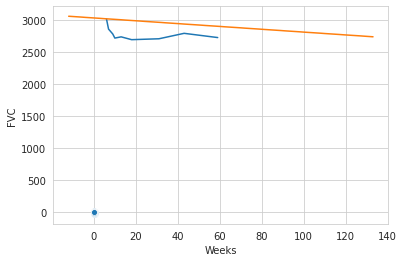

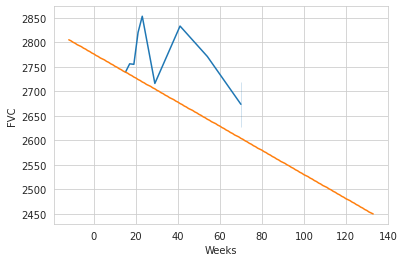

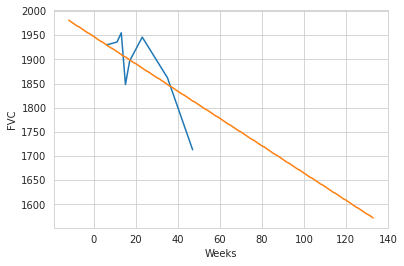

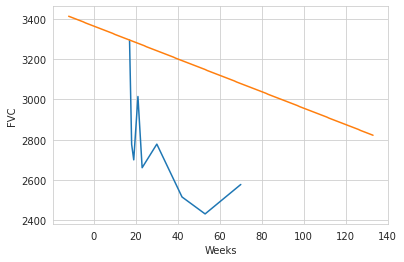

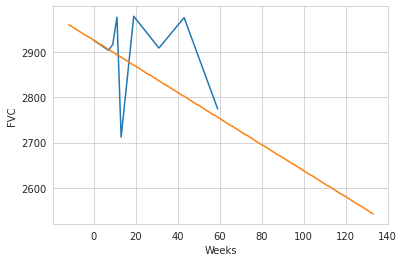

In [24]:
if INCLUDE_CT_DATA:
    sns.scatterplot(x='percentage_fibrotic_tissue', y='Gradient_Coef',data=df_unique_patients)

    p_id = list(df_test.Patient)

    for patient in p_id:
        print(df_unique_patients_test[df_unique_patients_test.index.str.startswith(patient)]['lung_volume_cm3'].values)
        print(df_unique_patients_test[df_unique_patients_test.index.str.startswith(patient)]['percentage_fibrotic_tissue'].values)
        x1 = range(-12, 134, 1)
        y1 = df_submission[df_submission.Patient_Week.str.startswith(patient)]['FVC'].values
        y1 = [int(i) for i in y1]
        sns.lineplot(x = "Weeks", y = "FVC", data = df_train[df_train.Patient == patient], markers = ["o", "<"])
        sns.lineplot(x = x1, y = y1, markers = ["o", "<"])
        plt.show()